## GPT-2 model def from scratch
+ 简易版

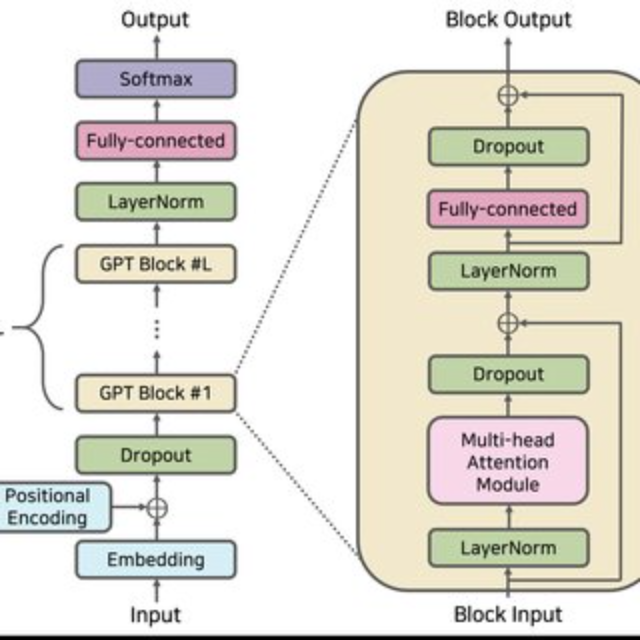
+ 详细版


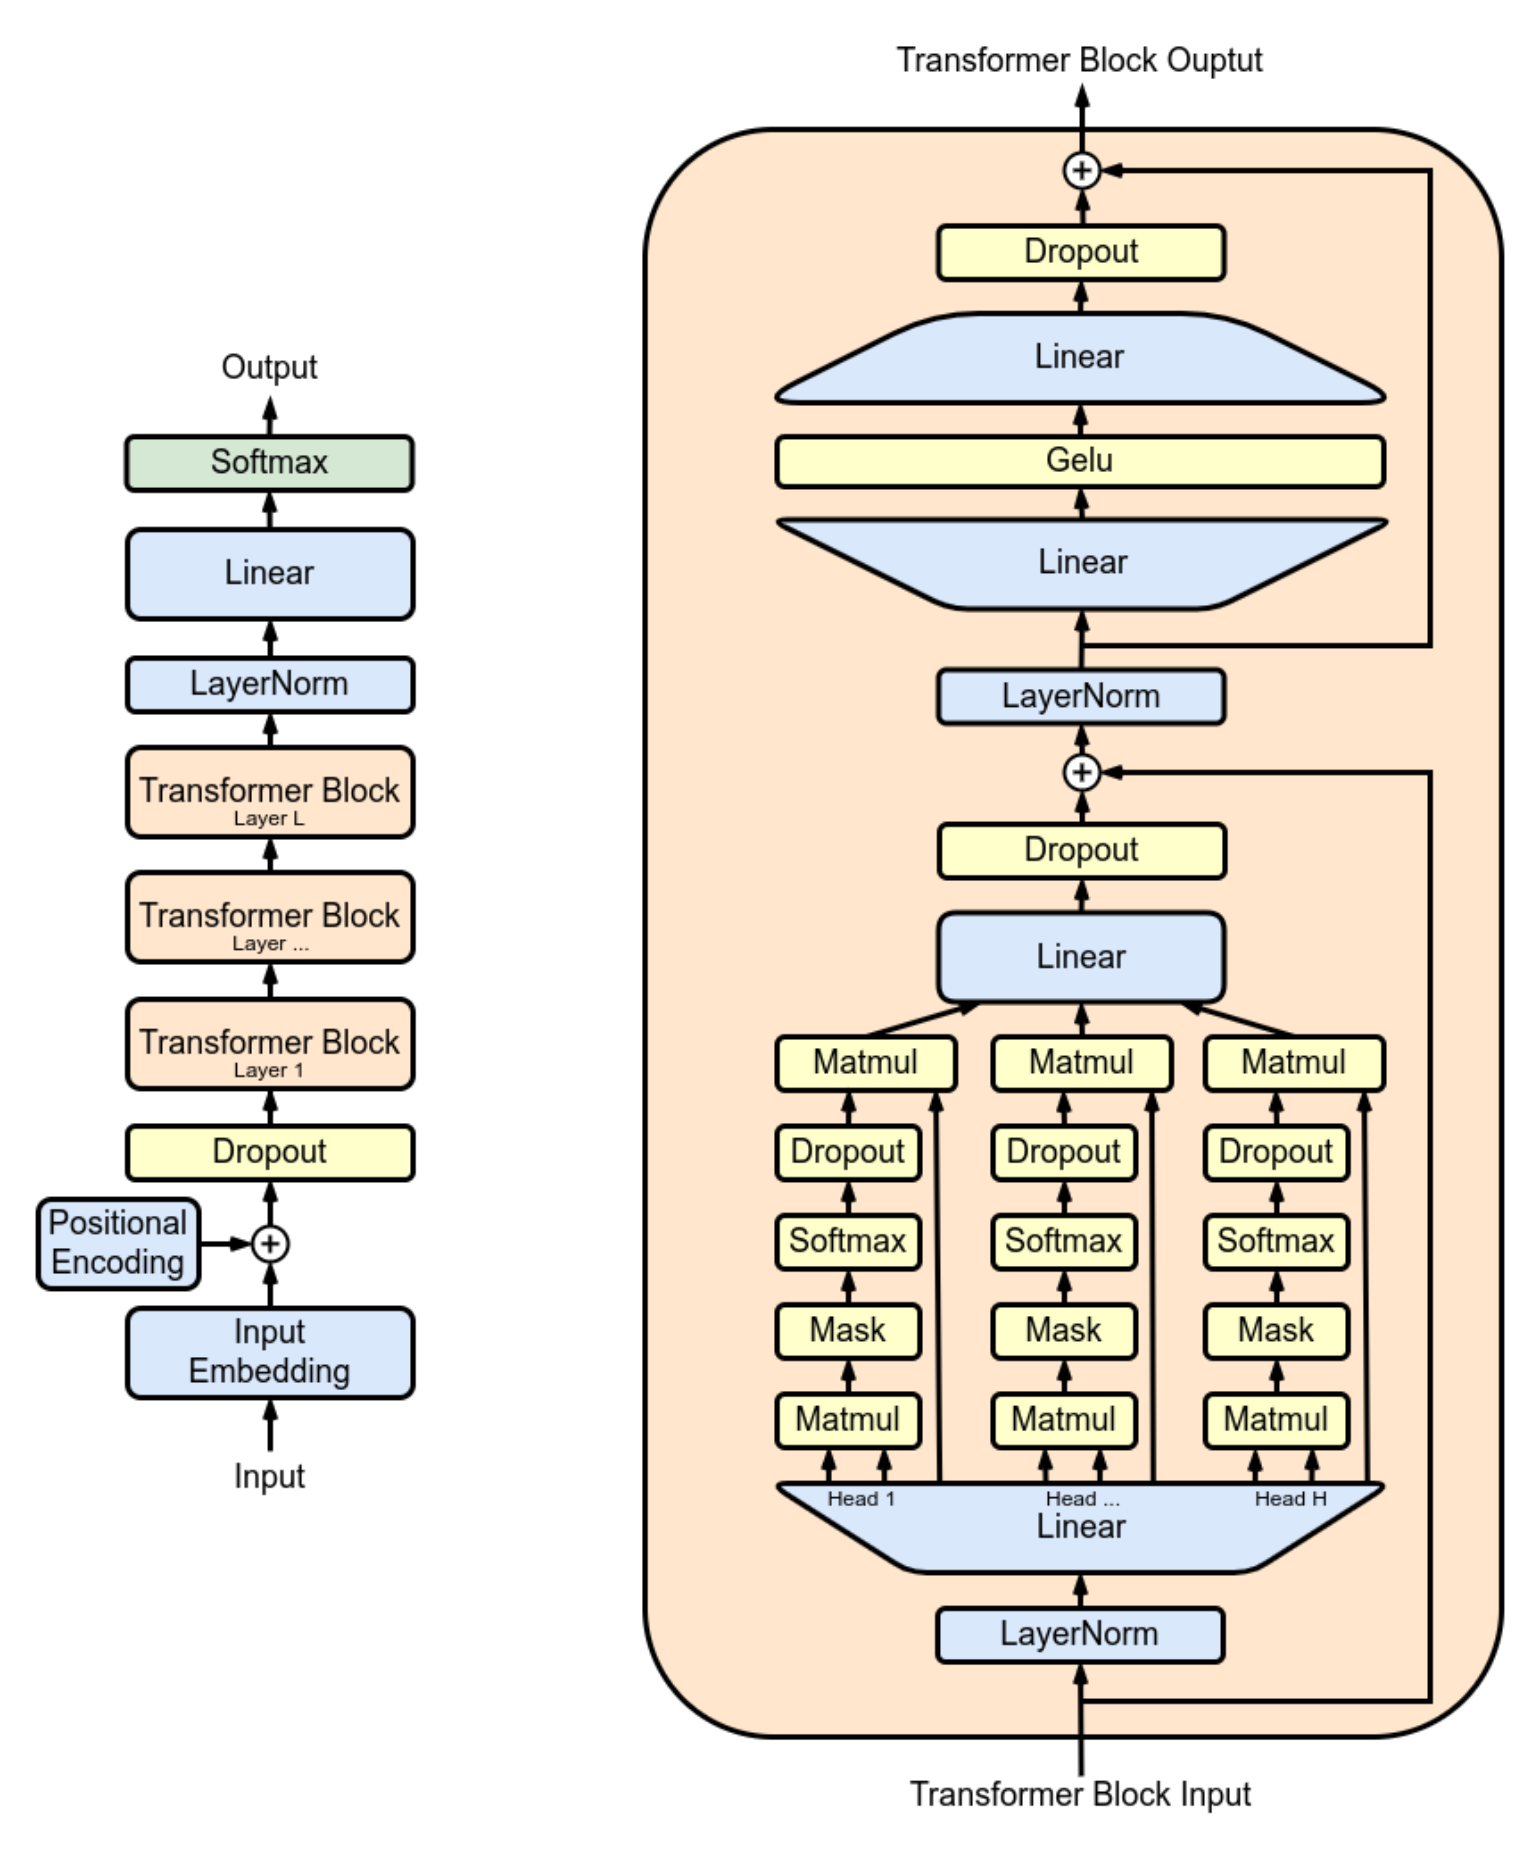

### import

In [1]:
import os
import math
import time
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
from hellaswag import render_example, iterate_examples

/home/gaozhe/anaconda3/envs/triton/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 分别实现各模块

#### Multi-head Attention

In [ ]:
class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)       # Q, K, V权重矩阵(水平拼接成一个矩阵)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # not really a 'bias', more of a mask, but following the OpenAI/HF naming though
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))       # 下三角矩阵作为mask
                                     .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)        # 相当于矩阵乘法: (B, T, C) @ (C, 3C) -> (B, T, 3C)
        q, k, v = qkv.split(self.n_embd, dim=2)     # 拆分成三个(B, T, C)tensor, 作为Q, K, V矩阵
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v

        # y = F.scaled_dot_product_attention(q, k, v, is_causal=True) # flash attention

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y

#### Feed-forward Network

In [4]:
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

#### Tranformer Block

In [2]:
class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

#### Hyperparameter

In [5]:
@dataclass
class GPTConfig:        # 可用于随机初始化
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension

#### GPT init

In [ ]:
class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),   # 每个token对应一个不同的向量
            wpe = nn.Embedding(config.block_size, config.n_embd),   # 每个位置对应一个不同的向量
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        # softmax前的最后一个线性层, 调整输出大小为token种类数，经过softmax后每个节点就是所代表token的概率
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

### Load openAI weights

In [5]:
@classmethod
def from_pretrained(cls, model_type):
    """Loads pretrained GPT-2 model weights from huggingface"""
    assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
    from transformers import GPT2LMHeadModel
    # print("loading weights from pretrained gpt: %s" % model_type)
    
    # Map model_type to the corresponding local path
    model_paths = {
        'gpt2': '/data/gz/gpt2',
        'gpt2-medium': '/data/gz/gpt2-medium',
        'gpt2-large': '/data/gz/gpt2-large',
        'gpt2-xl': '/data/gz/gpt2-xl',
    }
    model_path = model_paths[model_type]
    
    print(f"loading weights from local directory: {model_path}")

    # n_layer, n_head and n_embd are determined from model_type
    config_args = {
        'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
        'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
        'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
        'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
    }[model_type]
    config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
    config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
    # create a from-scratch initialized minGPT model (our model)
    config = GPTConfig(**config_args)
    model = GPT(config)
    sd = model.state_dict()
    sd_keys = sd.keys()
    sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

    # init a huggingface/transformers model
    # model_hf = GPT2LMHeadModel.from_pretrained(model_type)
    model_hf = GPT2LMHeadModel.from_pretrained(model_path, local_files_only=True) # 124M
    sd_hf = model_hf.state_dict()

    # copy while ensuring all of the parameters are aligned and match in names and shapes
    sd_keys_hf = sd_hf.keys()
    sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
    sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
    transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
    # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
    # this means that we have to transpose these weights when we import them
    assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
    for k in sd_keys_hf:
        if any(k.endswith(w) for w in transposed):
            # special treatment for the Conv1D weights we need to transpose
            assert sd_hf[k].shape[::-1] == sd[k].shape
            with torch.no_grad():
                sd[k].copy_(sd_hf[k].t())
        else:
            # vanilla copy over the other parameters
            assert sd_hf[k].shape == sd[k].shape
            with torch.no_grad():
                sd[k].copy_(sd_hf[k])

    return model

In [4]:
import os
import math
import time
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
from hellaswag import render_example, iterate_examples

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)       # Q, K, V权重矩阵(水平拼接成一个矩阵)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)     # 相乘后再拆分成Q, K, V矩阵
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True) # flash attention
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y
    
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x
    
class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)  # softmax前的最后一个线性层
    
    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        # print("loading weights from pretrained gpt: %s" % model_type)
        
        # Map model_type to the corresponding local path
        model_paths = {
            'gpt2': '/data/gz/gpt2',
            'gpt2-medium': '/data/gz/gpt2-medium',
            'gpt2-large': '/data/gz/gpt2-large',
            'gpt2-xl': '/data/gz/gpt2-xl',
        }
        model_path = model_paths[model_type]
        
        print(f"loading weights from local directory: {model_path}")

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model (our model)
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        # model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        model_hf = GPT2LMHeadModel.from_pretrained(model_path, local_files_only=True) # 124M
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model
    
model = GPT.from_pretrained('gpt2')
print(" didn't crash! ")

loading weights from local directory: /data/gz/gpt2
 didn't crash! 


### forward pass

In [ ]:
def forward(self, idx, targets=None):
    # idx is of shape (B, T)
    B, T = idx.size()
    # block_size 即最长token数
    assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
    # forward the token and posisition embeddings
    pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
    pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd) ----每行都一模一样
    tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
    x = tok_emb + pos_emb
    # forward the blocks of the transformer
    for block in self.transformer.h:
        x = block(x)
    # forward the final layernorm and the classifier
    x = self.transformer.ln_f(x)
    logits = self.lm_head(x) # (B, T, vocab_size)
    loss = None
    if targets is not None:
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
    return logits, loss

### Test
+ 导入权重并自定义prompt进行推理

In [ ]:
import os
import math
import time
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
from hellaswag import render_example, iterate_examples

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)       # Q, K, V权重矩阵(水平拼接成一个矩阵)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # not really a 'bias', more of a mask, but following the OpenAI/HF naming though
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))       # 下三角矩阵作为mask
                                     .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)     # 相乘后再拆分成Q, K, V矩阵
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v

        # y = F.scaled_dot_product_attention(q, k, v, is_causal=True) # flash attention

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y
    
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x
    
class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)  # softmax前的最后一个线性层
        
    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        # print("loading weights from pretrained gpt: %s" % model_type)
        
        # Map model_type to the corresponding local path
        model_paths = {
            'gpt2': '/data/gz/gpt2',
            'gpt2-medium': '/data/gz/gpt2-medium',
            'gpt2-large': '/data/gz/gpt2-large',
            'gpt2-xl': '/data/gz/gpt2-xl',
        }
        model_path = model_paths[model_type]
        
        print(f"loading weights from local directory: {model_path}")

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model (our model)
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        # model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        model_hf = GPT2LMHeadModel.from_pretrained(model_path, local_files_only=True) # 从本地导入weights
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model
    


# ------------------
num_return_sequences = 5
max_length = 30
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

model = GPT.from_pretrained('gpt2')     # gpt2官方参数
# model = GPT(GPTConfig())    # 随机初始化
model.eval()
model.to(device)

# prefix tokens (即定义一个prompt:"Hello, I'm a language model,")
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2') # gpt2 tokenizer
tokens = tokenizer.encode("Hello, I'm a language model,")
tokens = torch.tensor(tokens, dtype=torch.long)     # (8,)向量
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)    # 重复5便变成(5, 8)矩阵
x = tokens.to(device)


# generate
torch.manual_seed(42)
torch.cuda.manual_seed(42)
while x.size(1) < max_length:   # 不断循环推理，直到输出长度为max_length(30)
    # forward
    with torch.no_grad():
        logits, _ = model(x)      # (B, T, vocab_size)
        # 提取最后一个位置（只需要最后一个位置，因为每个位置都是下一个位置的预测）
        logits = logits[:, -1, :]   # (B, vocab_size)
        # 经过softmax得到预测概率
        probs = F.softmax(logits, dim=-1)
        # 选择概率前50的token概率，50名之后全部置零
        topk_probs, topk_ids = torch.topk(probs, 50, dim=-1)    # (B, 50)
        iout = torch.multinomial(topk_probs, 1)     # 50个概率中抽一个(概率越高越容易抽到，但不一定), 返回所在topk_prob中的idx
        out_idx = torch.gather(topk_ids, -1, iout)  # 一维时相当于out_idx = topk_ids[iout]
        x = torch.cat((x, out_idx), dim=-1)

# print
for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist()
    decoded = tokenizer.decode(tokens)
    print(">", decoded)


> Hello, I'm a language model, disappoint shoutedeneUAL Lans patientLicenseALTH Rams RL hungry antidaturationJRainment defects125listedVPN gcc135 livestock
> Hello, I'm a language model, despite hierarchylonhip pinchActually Registrar Priorityopathic running syndrome WildJBquist der starter insanely theoretically Edmonton205 serve newer
> Hello, I'm a language model, Crime excited pivotaljri Whit ElderMachine decriminal vows unlimited893idis PlayStation bart Lemoningly bedrock Electrical pythonmo770 beginnings
> Hello, I'm a language model,ubi dreaming Establishment deleg Sidney dualLicense coup resolves regrets damaged rugby PlayStationotide25 inflict'll messages comb192 lik multimedia
> Hello, I'm a language model, Investigation summarized++;ヴァ colonialism drilling obscene STOR invaluable Adrian Healeridis shedJune playful Severuscontact migrating═ intimately URFe


## Pre-train from scratch

### data prep (tiny shakespeare)

In [2]:
# tiny shakespeare dataset
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r') as f:
    text = f.read()
data = text[:1000] # first 1,000 characters
print(data[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


#### tokenize

In [3]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode(data)
print(tokens[:24])

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


#### input & target

In [4]:
import torch
buf = torch.tensor(tokens[:24+1])   # 一个batch为 4*6=24
x = buf[:-1].view(4, 6)     # input 
y = buf[1:].view(4, 6)      # target 右移1个token
print(x)
print(y)        # y的每个元素都是x对应元素的后一个

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


#### simple test

In [13]:
# model def
# -----------------
import tiktoken
enc = tiktoken.get_encoding('gpt2')
with open('input.txt', 'r') as f:
    text = f.read()

data = text[:1000]          # 用前1000个字符做简单测试
tokens = enc.encode(data)
B, T = 4, 32
buf = torch.tensor(tokens[:B*T+1])
buf = buf.to(device)                    # to(device)在device上复制数据, 返回指向这个device数据的指针
x = buf[:-1].view(B, T)     # input 
y = buf[1:].view(B, T)      # target

# get logits
model = GPT(GPTConfig())
# model.to('cpu')
model.to(device)
logits, _ = model(x)

print(logits.shape)

torch.Size([4, 32, 50257])


### Calculate Loss
+ `logits, loss = model(x, y)`——在forward pass中计算loss

In [ ]:
def forward(self, idx, targets=None):
    # idx is of shape (B, T)
    # B, T = idx.size()
    # assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
    # # forward the token and posisition embeddings
    # pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
    # pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
    # tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
    # x = tok_emb + pos_emb
    # # forward the blocks of the transformer
    # for block in self.transformer.h:
    #     x = block(x)
    # # forward the final layernorm and the classifier
    # x = self.transformer.ln_f(x)
    # logits = self.lm_head(x) # (B, T, vocab_size)
    loss = None
    if targets is not None:     # 如果传入了target
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))  # logits转为二维(B*T, vocab_size), targets为(B*T,)
    return logits, loss

### Optimize

In [14]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)
for i in range(50):
    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward() 
    optimizer.step()
    print(f"step {i}, loss: {loss.item()}")

step 0, loss: 11.038883209228516
step 1, loss: 6.679925918579102
step 2, loss: 4.402685642242432
step 3, loss: 2.704627752304077
step 4, loss: 1.5486470460891724
step 5, loss: 0.8769501447677612
step 6, loss: 0.4879806935787201
step 7, loss: 0.2834359407424927
step 8, loss: 0.18019603192806244
step 9, loss: 0.11913473904132843
step 10, loss: 0.07868140190839767
step 11, loss: 0.057134732604026794
step 12, loss: 0.043651238083839417
step 13, loss: 0.03486088663339615
step 14, loss: 0.029699310660362244
step 15, loss: 0.025984445586800575
step 16, loss: 0.022558536380529404
step 17, loss: 0.019513918086886406
step 18, loss: 0.017059095203876495
step 19, loss: 0.015091463923454285
step 20, loss: 0.013475719839334488
step 21, loss: 0.012109518982470036
step 22, loss: 0.010920340195298195
step 23, loss: 0.009877458214759827
step 24, loss: 0.008972384966909885
step 25, loss: 0.008196897804737091
step 26, loss: 0.007537119556218386
step 27, loss: 0.0069757611490786076
step 28, loss: 0.0064956

### DataLoader

In [1]:
import tiktoken

class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T

        enc = tiktoken.get_encoding('gpt2')
        with open('input.txt', 'r') as f:
            text = f.read()
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        
        print(f"loaded {len(self.tokens)} tokens")                  # token总数
        print(f"1 epoch = {len(self.tokens) // (B*T)} batchs")      # batch总数

        # state
        self.current_position = 0

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position + B*T + 1]
        x = buf[:-1].view(B, T)     # input 
        y = buf[1:].view(B, T)      # target

        self.current_position += B*T
        # boundary check
        if self.current_position + (B*T+1) > len(self.tokens):
            self.current_position = 0       # 越界就舍弃最后一个batch
        return x, y

In [ ]:
train_loader = DataLoaderLite(4, 32)

### Sharing weights
+ token embedding layer 和 softmax前的linear layer(lm_head) 权重应完全相同

+ 输入时：语义相似token的embedding也应该相近

+ 输出时：语义相似token的预测概率也应该相近

In [9]:
class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),       # 由于 weight sharing scheme, 这个权重相当于没有
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)  # softmax前的最后一个线性层

        # weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight   # 复制指针，两者指向同一块数据，因此在训练后也相等

In [10]:
w = nn.Linear(20, 30)
w.weight.shape

torch.Size([30, 20])

### Initialization 优化

```python
class GPT(nn.Module):

    # def __init__(self, config):
    #     super().__init__()
    #     self.config = config

    #     self.transformer = nn.ModuleDict(dict(
    #         wte = nn.Embedding(config.vocab_size, config.n_embd),
    #         wpe = nn.Embedding(config.block_size, config.n_embd),
    #         h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
    #         ln_f = nn.LayerNorm(config.n_embd),
    #     ))
    #     self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    #     # weight sharing scheme
    #     self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

```python
class CausalSelfAttention(nn.Module):

    # def __init__(self, config):
    #     super().__init__()
    #     assert config.n_embd % config.n_head == 0
    #     # key, query, value projections for all heads, but in a batch
    #     self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
    #     # output projection
    #     self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        # regularization
        # self.n_head = config.n_head
        # self.n_embd = config.n_embd

```python
class MLP(nn.Module):

    # def __init__(self, config):
    #     super().__init__()
    #     self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
    #     self.gelu    = nn.GELU(approximate='tanh')
    #     self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

### Simple training loop

In [1]:
import os
import math
import time
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
import tiktoken
from hellaswag import render_example, iterate_examples

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)       # Q, K, V权重矩阵(水平拼接成一个矩阵)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # not really a 'bias', more of a mask, but following the OpenAI/HF naming though
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))       # 下三角矩阵作为mask
                                     .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)     # 相乘后再拆分成Q, K, V矩阵
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v

        # y = F.scaled_dot_product_attention(q, k, v, is_causal=True) # flash attention

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y
    
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        # print("loading weights from pretrained gpt: %s" % model_type)
        
        # Map model_type to the corresponding local path
        model_paths = {
            'gpt2': '/data/gz/gpt2',
            'gpt2-medium': '/data/gz/gpt2-medium',
            'gpt2-large': '/data/gz/gpt2-large',
            'gpt2-xl': '/data/gz/gpt2-xl',
        }
        model_path = model_paths[model_type]
        
        print(f"loading weights from local directory: {model_path}")

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model (our model)
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        # model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        model_hf = GPT2LMHeadModel.from_pretrained(model_path, local_files_only=True) # 从本地导入weights
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model
    

class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T

        enc = tiktoken.get_encoding('gpt2')
        with open('input.txt', 'r') as f:
            text = f.read()
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        
        print(f"loaded {len(self.tokens)} tokens")                  # token总数
        print(f"1 epoch = {len(self.tokens) // (B*T)} batchs")      # batch总数

        # state
        self.current_position = 0

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position + B*T + 1]
        x = buf[:-1].view(B, T)     # input 
        y = buf[1:].view(B, T)      # target

        self.current_position += B*T
        # boundary check
        if self.current_position + (B*T+1) > len(self.tokens):
            self.current_position = 0       # 越界就舍弃最后一个batch
        return x, y

# ------------------
# num_return_sequences = 5
# max_length = 30
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
train_loader = DataLoaderLite(B=4, T=32)

# model = GPT.from_pretrained('gpt2')     # gpt2官方参数
model = GPT(GPTConfig())    # 随机初始化
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)

for i in range(50):     # 50 batches
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward() 
    optimizer.step()
    print(f"step {i}, loss: {loss.item()}")

/home/gaozhe/anaconda3/envs/triton/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loaded 338025 tokens
1 epoch = 2640 batchs
step 0, loss: 10.888320922851562
step 1, loss: 9.695329666137695
step 2, loss: 9.203083038330078
step 3, loss: 9.201865196228027
step 4, loss: 8.66898250579834
step 5, loss: 8.414339065551758
step 6, loss: 9.033819198608398
step 7, loss: 8.78188419342041
step 8, loss: 8.114378929138184
step 9, loss: 8.023765563964844
step 10, loss: 8.437297821044922
step 11, loss: 7.490137577056885
step 12, loss: 7.8624653816223145
step 13, loss: 7.435051918029785
step 14, loss: 7.565485954284668
step 15, loss: 7.387190818786621
step 16, loss: 7.488323211669922
step 17, loss: 8.224709510803223
step 18, loss: 7.2212677001953125
step 19, loss: 7.761362075805664
step 20, loss: 7.5535430908203125
step 21, loss: 7.764084815979004
step 22, loss: 6.520586013793945
step 23, loss: 6.881639003753662
step 24, loss: 6.9292449951171875
step 25, loss: 6.744142532348633
step 26, loss: 6.882659435272217
step 27, loss: 7.669747829437256
step 28, loss: 7.237325191497803
step 29

## Speed up

### TF32 precision

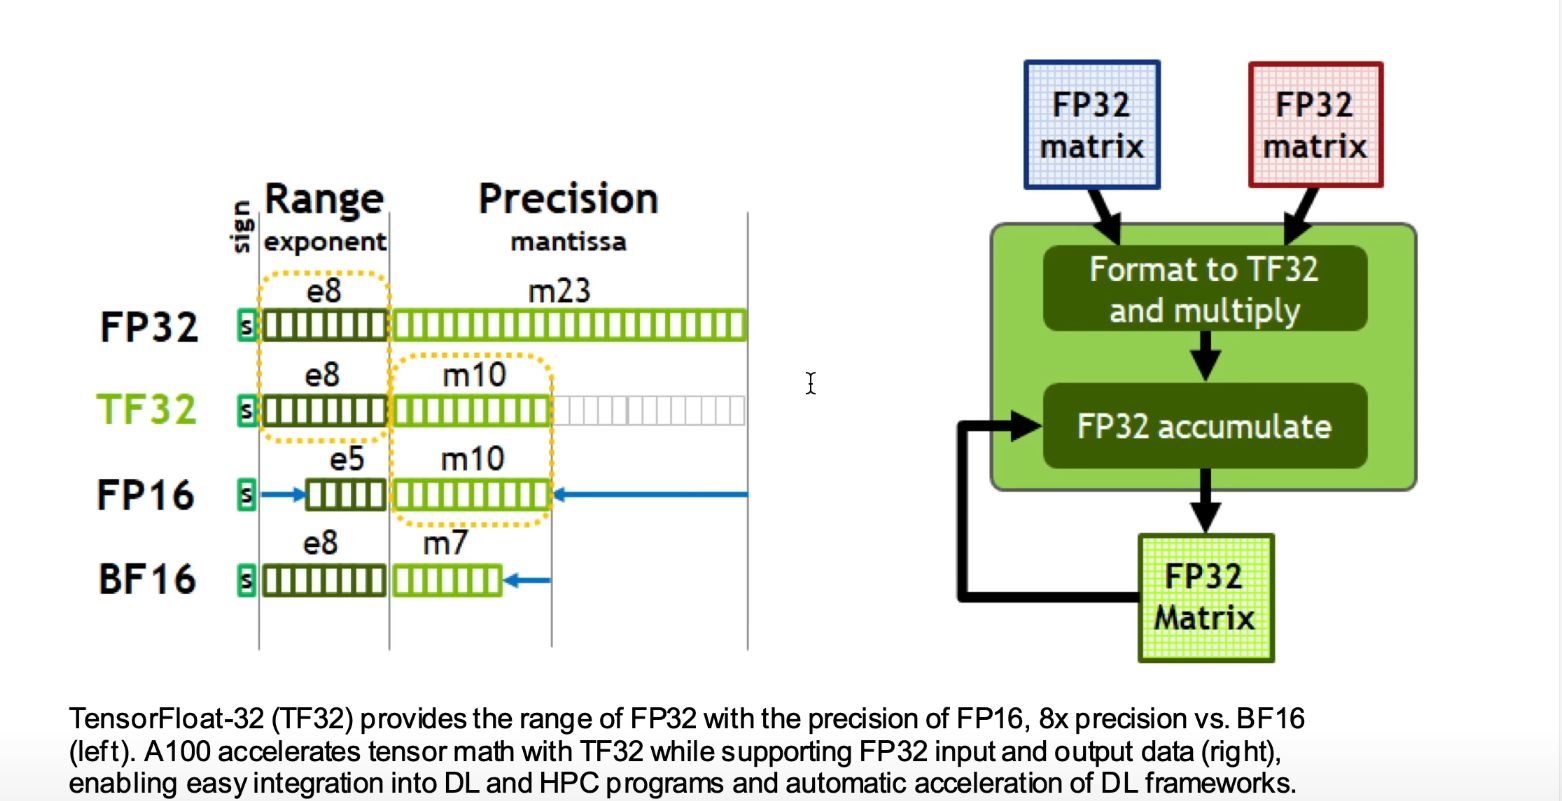

In [ ]:
# enable TF32
torch.set_float32_matmul_precision('high')

增加每batch训练耗时+token吞吐量（每秒token数）：

```python
for i in range(50):     # 50 batches

    t0 = time.time()

    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward() 
    optimizer.step()

    torch.cuda.synchronize()
    t1 = time.time()
    dt = (t1-t0) * 1000         # 时间差（单位：ms）
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1-t0)
    print(f"step {i}, loss: {loss.item()}, dt: {dt:.2f}ms, tok/sec: {tokens_per_sec:.2f}")

#### Before(Float32):

In [2]:
import os
import math
import time
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
import tiktoken
from hellaswag import render_example, iterate_examples

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)       # Q, K, V权重矩阵(水平拼接成一个矩阵)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # not really a 'bias', more of a mask, but following the OpenAI/HF naming though
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))       # 下三角矩阵作为mask
                                     .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)     # 相乘后再拆分成Q, K, V矩阵
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v

        # y = F.scaled_dot_product_attention(q, k, v, is_causal=True) # flash attention

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y
    
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        # print("loading weights from pretrained gpt: %s" % model_type)
        
        # Map model_type to the corresponding local path
        model_paths = {
            'gpt2': '/data/gz/gpt2',
            'gpt2-medium': '/data/gz/gpt2-medium',
            'gpt2-large': '/data/gz/gpt2-large',
            'gpt2-xl': '/data/gz/gpt2-xl',
        }
        model_path = model_paths[model_type]
        
        print(f"loading weights from local directory: {model_path}")

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model (our model)
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        # model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        model_hf = GPT2LMHeadModel.from_pretrained(model_path, local_files_only=True) # 从本地导入weights
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model
    

class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T

        enc = tiktoken.get_encoding('gpt2')
        with open('input.txt', 'r') as f:
            text = f.read()
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        
        print(f"loaded {len(self.tokens)} tokens")                  # token总数
        print(f"1 epoch = {len(self.tokens) // (B*T)} batchs")      # batch总数

        # state
        self.current_position = 0

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position + B*T + 1]
        x = buf[:-1].view(B, T)     # input 
        y = buf[1:].view(B, T)      # target

        self.current_position += B*T
        # boundary check
        if self.current_position + (B*T+1) > len(self.tokens):
            self.current_position = 0       # 越界就舍弃最后一个batch
        return x, y

# ------------------
torch.cuda.manual_seed(1337)

# device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
device = "cuda:3" if torch.cuda.is_available() else "cpu"
train_loader = DataLoaderLite(B=16, T=512)

# enable TF32
# torch.set_float32_matmul_precision('highest')

# model = GPT.from_pretrained('gpt2')     # gpt2官方参数
model = GPT(GPTConfig())    # 随机初始化
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)

for i in range(50):     # 50 batches

    t0 = time.time()

    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward() 
    optimizer.step()

    torch.cuda.synchronize()
    t1 = time.time()
    dt = (t1-t0) * 1000         # 时间差（单位：ms）
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1-t0)
    print(f"step {i}, loss: {loss.item()}, dt: {dt:.2f}ms, tok/sec: {tokens_per_sec:.2f}")

loaded 338025 tokens
1 epoch = 41 batchs
step 0, loss: 10.874634742736816, dt: 82.51ms, tok/sec: 99288.38
step 1, loss: 9.512629508972168, dt: 34.24ms, tok/sec: 239228.96
step 2, loss: 8.803573608398438, dt: 36.41ms, tok/sec: 224974.88
step 3, loss: 8.666921615600586, dt: 34.38ms, tok/sec: 238291.57
step 4, loss: 8.428585052490234, dt: 35.43ms, tok/sec: 231187.22
step 5, loss: 8.346573829650879, dt: 34.15ms, tok/sec: 239855.21
step 6, loss: 8.29799747467041, dt: 34.69ms, tok/sec: 236164.01
step 7, loss: 7.953546524047852, dt: 37.48ms, tok/sec: 218585.91
step 8, loss: 7.663825511932373, dt: 36.28ms, tok/sec: 225777.60
step 9, loss: 7.641384124755859, dt: 34.36ms, tok/sec: 238442.05
step 10, loss: 7.627506256103516, dt: 34.79ms, tok/sec: 235443.88
step 11, loss: 7.45004415512085, dt: 34.29ms, tok/sec: 238884.68
step 12, loss: 7.397706508636475, dt: 36.88ms, tok/sec: 222102.74
step 13, loss: 7.205280780792236, dt: 34.44ms, tok/sec: 237831.39
step 14, loss: 7.097269535064697, dt: 34.28ms, 

#### After(TF32):

In [3]:
import os
import math
import time
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
import tiktoken
from hellaswag import render_example, iterate_examples

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)       # Q, K, V权重矩阵(水平拼接成一个矩阵)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # not really a 'bias', more of a mask, but following the OpenAI/HF naming though
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))       # 下三角矩阵作为mask
                                     .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)     # 相乘后再拆分成Q, K, V矩阵
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v

        # y = F.scaled_dot_product_attention(q, k, v, is_causal=True) # flash attention

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y
    
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        # print("loading weights from pretrained gpt: %s" % model_type)
        
        # Map model_type to the corresponding local path
        model_paths = {
            'gpt2': '/data/gz/gpt2',
            'gpt2-medium': '/data/gz/gpt2-medium',
            'gpt2-large': '/data/gz/gpt2-large',
            'gpt2-xl': '/data/gz/gpt2-xl',
        }
        model_path = model_paths[model_type]
        
        print(f"loading weights from local directory: {model_path}")

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model (our model)
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        # model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        model_hf = GPT2LMHeadModel.from_pretrained(model_path, local_files_only=True) # 从本地导入weights
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model
    

class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T

        enc = tiktoken.get_encoding('gpt2')
        with open('input.txt', 'r') as f:
            text = f.read()
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        
        print(f"loaded {len(self.tokens)} tokens")                  # token总数
        print(f"1 epoch = {len(self.tokens) // (B*T)} batchs")      # batch总数

        # state
        self.current_position = 0

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position + B*T + 1]
        x = buf[:-1].view(B, T)     # input 
        y = buf[1:].view(B, T)      # target

        self.current_position += B*T
        # boundary check
        if self.current_position + (B*T+1) > len(self.tokens):
            self.current_position = 0       # 越界就舍弃最后一个batch
        return x, y

# ------------------
torch.cuda.manual_seed(1337)

# device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
device = "cuda:3" if torch.cuda.is_available() else "cpu"
train_loader = DataLoaderLite(B=16, T=512)

# enable TF32
torch.set_float32_matmul_precision('high')

# model = GPT.from_pretrained('gpt2')     # gpt2官方参数
model = GPT(GPTConfig())    # 随机初始化
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)

for i in range(50):     # 50 batches

    t0 = time.time()

    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward() 
    optimizer.step()

    torch.cuda.synchronize()
    t1 = time.time()
    dt = (t1-t0) * 1000         # 时间差（单位：ms）
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1-t0)
    print(f"step {i}, loss: {loss.item()}, dt: {dt:.2f}ms, tok/sec: {tokens_per_sec:.2f}")

loaded 338025 tokens
1 epoch = 41 batchs
step 0, loss: 10.876832008361816, dt: 38.25ms, tok/sec: 214147.41
step 1, loss: 9.557924270629883, dt: 33.92ms, tok/sec: 241488.71
step 2, loss: 9.876606941223145, dt: 35.19ms, tok/sec: 232799.02
step 3, loss: 8.90848159790039, dt: 33.31ms, tok/sec: 245907.98
step 4, loss: 8.572265625, dt: 33.81ms, tok/sec: 242301.02
step 5, loss: 8.423582077026367, dt: 33.67ms, tok/sec: 243282.34
step 6, loss: 8.37811279296875, dt: 33.53ms, tok/sec: 244295.96
step 7, loss: 8.093851089477539, dt: 33.23ms, tok/sec: 246539.65
step 8, loss: 7.77040958404541, dt: 35.55ms, tok/sec: 230429.06
step 9, loss: 7.713821887969971, dt: 35.41ms, tok/sec: 231378.71
step 10, loss: 7.711212158203125, dt: 35.34ms, tok/sec: 231792.35
step 11, loss: 7.534786224365234, dt: 33.50ms, tok/sec: 244548.08
step 12, loss: 7.491695404052734, dt: 36.30ms, tok/sec: 225670.83
step 13, loss: 7.2833099365234375, dt: 35.37ms, tok/sec: 231631.40
step 14, loss: 7.206564903259277, dt: 34.35ms, tok/s

### Automatic mixed precision

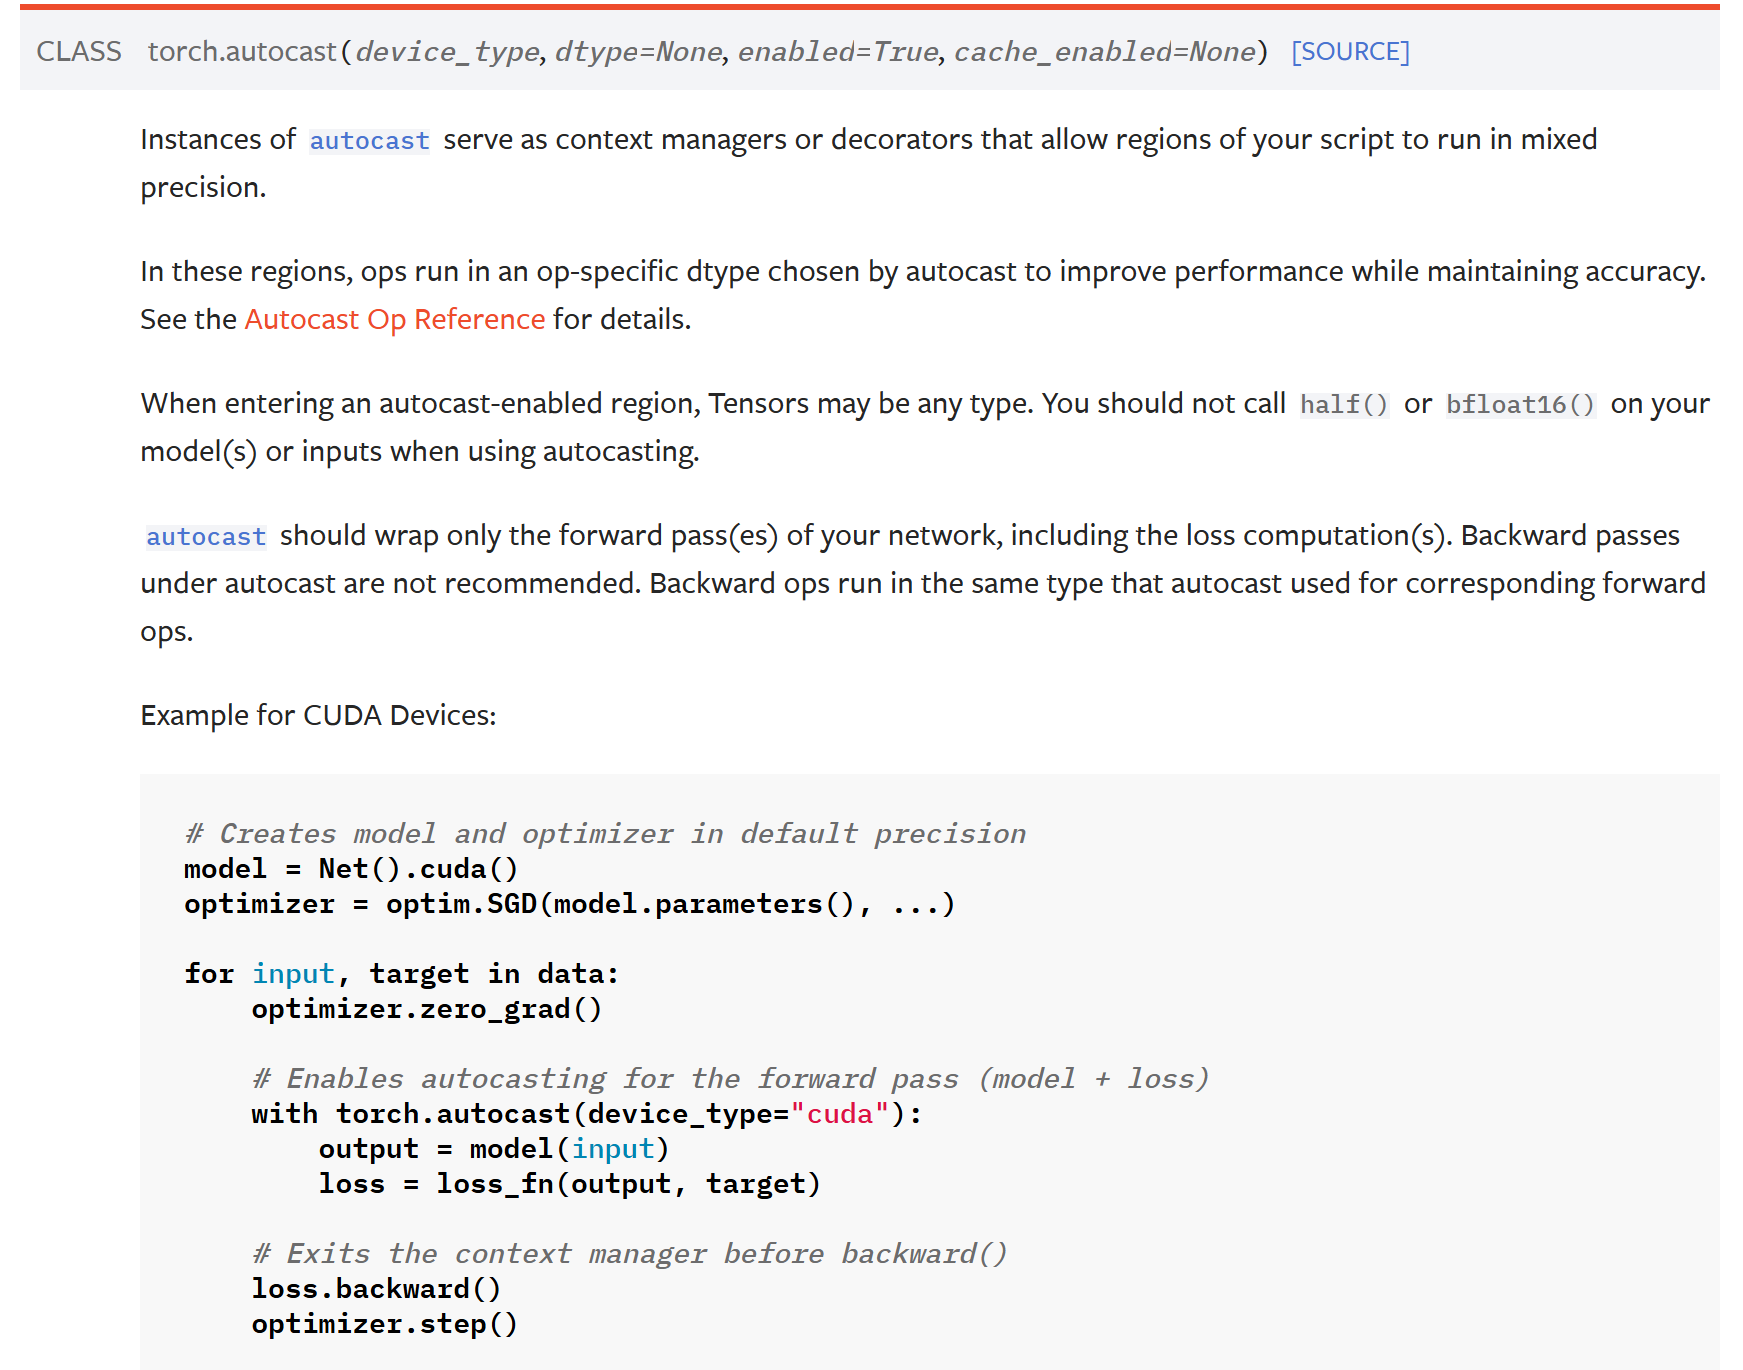

In [4]:
import os
import math
import time
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
import tiktoken
from hellaswag import render_example, iterate_examples

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)       # Q, K, V权重矩阵(水平拼接成一个矩阵)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # not really a 'bias', more of a mask, but following the OpenAI/HF naming though
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))       # 下三角矩阵作为mask
                                     .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)     # 相乘后再拆分成Q, K, V矩阵
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v

        # y = F.scaled_dot_product_attention(q, k, v, is_causal=True) # flash attention

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y
    
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        # print("loading weights from pretrained gpt: %s" % model_type)
        
        # Map model_type to the corresponding local path
        model_paths = {
            'gpt2': '/data/gz/gpt2',
            'gpt2-medium': '/data/gz/gpt2-medium',
            'gpt2-large': '/data/gz/gpt2-large',
            'gpt2-xl': '/data/gz/gpt2-xl',
        }
        model_path = model_paths[model_type]
        
        print(f"loading weights from local directory: {model_path}")

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model (our model)
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        # model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        model_hf = GPT2LMHeadModel.from_pretrained(model_path, local_files_only=True) # 从本地导入weights
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model
    

class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T

        enc = tiktoken.get_encoding('gpt2')
        with open('input.txt', 'r') as f:
            text = f.read()
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        
        print(f"loaded {len(self.tokens)} tokens")                  # token总数
        print(f"1 epoch = {len(self.tokens) // (B*T)} batchs")      # batch总数

        # state
        self.current_position = 0

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position + B*T + 1]
        x = buf[:-1].view(B, T)     # input 
        y = buf[1:].view(B, T)      # target

        self.current_position += B*T
        # boundary check
        if self.current_position + (B*T+1) > len(self.tokens):
            self.current_position = 0       # 越界就舍弃最后一个batch
        return x, y

# ------------------
torch.cuda.manual_seed(1337)

# device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
device = "cuda:3" if torch.cuda.is_available() else "cpu"
train_loader = DataLoaderLite(B=16, T=512)

# enable TF32
torch.set_float32_matmul_precision('high')

# model = GPT.from_pretrained('gpt2')     # gpt2官方参数
model = GPT(GPTConfig())    # 随机初始化
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)

for i in range(50):     # 50 batches
    t0 = time.time()
    x, y = train_loader.next_batch()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()

    with torch.autocast(device_type=device, dtype=torch.bfloat16):
        logits, loss = model(x, y)
        # import code; code.interact(local=locals())      # 运行到此处暂停可调试
    loss.backward() 
    optimizer.step()
    torch.cuda.synchronize()    # wait for GPU to finish work
    t1 = time.time()
    dt = (t1-t0) * 1000         # 时间差（单位：ms）
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1-t0)
    print(f"step {i}, loss: {loss.item()}, dt: {dt:.2f}ms, tok/sec: {tokens_per_sec:.2f}")

loaded 338025 tokens
1 epoch = 41 batchs
step 0, loss: 10.910911560058594, dt: 71.32ms, tok/sec: 114862.88
step 1, loss: 9.514972686767578, dt: 40.49ms, tok/sec: 202310.09
step 2, loss: 9.09878158569336, dt: 38.70ms, tok/sec: 211688.15
step 3, loss: 8.59956169128418, dt: 39.04ms, tok/sec: 209849.69
step 4, loss: 8.542458534240723, dt: 38.57ms, tok/sec: 212402.64
step 5, loss: 8.423466682434082, dt: 39.88ms, tok/sec: 205397.64
step 6, loss: 8.323823928833008, dt: 38.86ms, tok/sec: 210828.28
step 7, loss: 8.004373550415039, dt: 39.66ms, tok/sec: 206570.75
step 8, loss: 7.722116470336914, dt: 40.74ms, tok/sec: 201077.60
step 9, loss: 7.6805877685546875, dt: 39.17ms, tok/sec: 209164.97
step 10, loss: 7.669849395751953, dt: 38.60ms, tok/sec: 212222.91
step 11, loss: 7.476737976074219, dt: 40.34ms, tok/sec: 203074.14
step 12, loss: 7.42487907409668, dt: 39.83ms, tok/sec: 205687.82
step 13, loss: 7.20928955078125, dt: 40.82ms, tok/sec: 200699.41
step 14, loss: 7.113478660583496, dt: 38.85ms, 

### torch.compile
只需一行代码：
```python
# model = GPT(GPTconfig())
# model.to(device)
model = torch.compile(model)

### Flash Attention
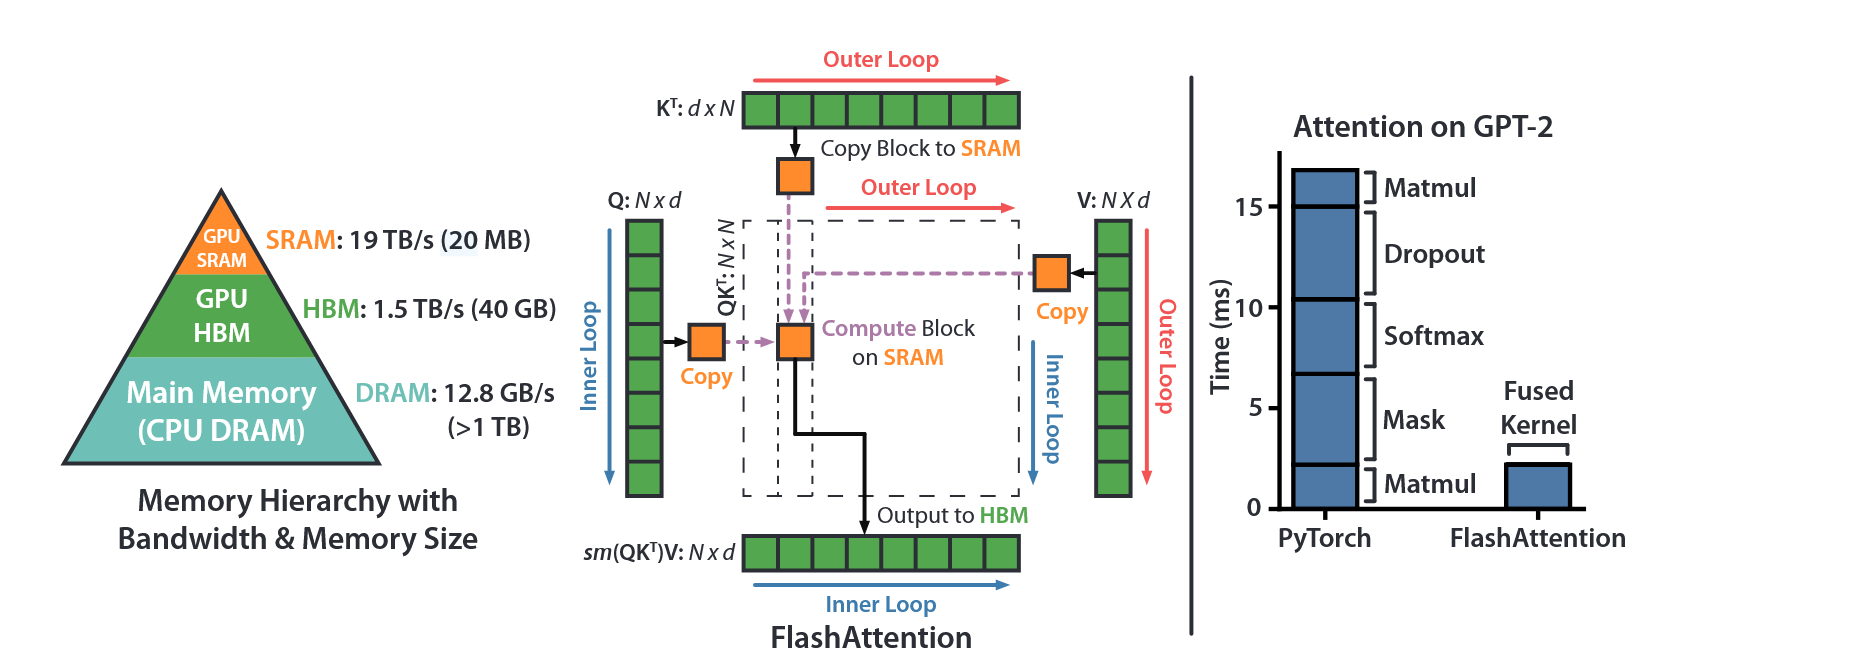

naive attention
```python
att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
att = F.softmax(att, dim=-1)
y = att @ v
```
flash attention
```python
y = F.scaled_dot_product_attention(q, k, v, is_causal=True)
```

### nice numbers
+ block_size、B、T等参数最好设为2的次幂(nice number)，而不是奇数甚至素数
+ 几乎任何参数都最好设为nice number

```python
model = GPT(GPTConfig(vocab_size=50304))   # add fake tokens（分类时需要手动调整fake token概率为0)

### hyperparameter 优化 (参考GPT-3)
#### 1. AdamW

```python
optimizer = torch.optim(AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.95), eps=1e-8)
```

#### 2. gradient clipping

```python
with torch.autocast(device_type=device, dtype=torch.bfloat16):
    logits, loss = model(x, y)
    # import code; code.interact(local=locals())      # 运行到此处暂停可调试
loss.backward() 
norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
```

#### 3. learning rate decay
lr变化曲线

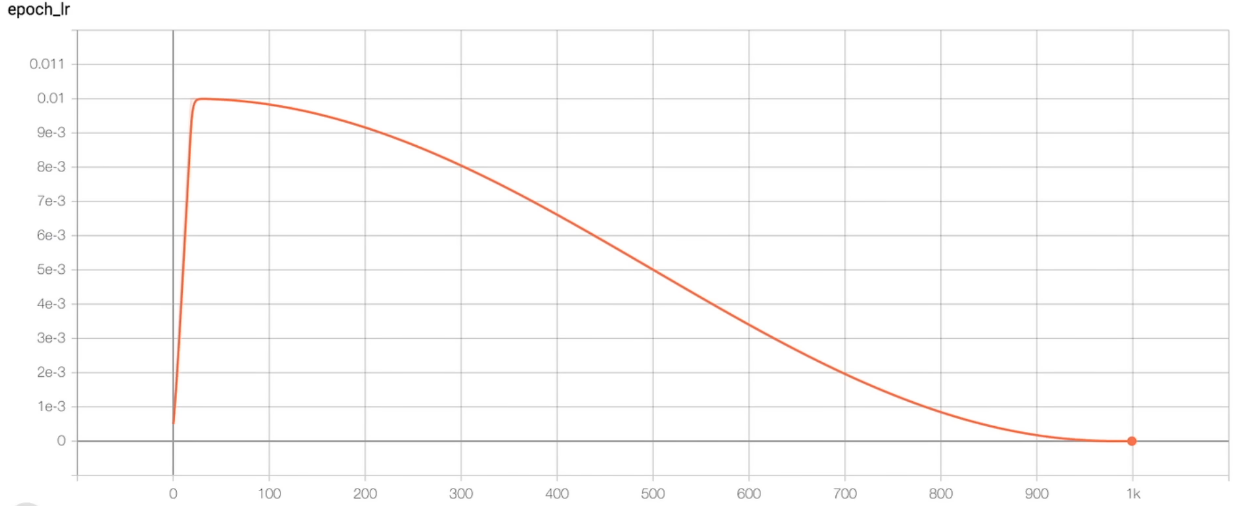

```python
max_lr = 6e-4
min_lr = max_lr * 0.1
warmup_steps = 715
max_steps = 19073 # 19,073 steps is ~1 epoch, if data is 10B tokens and batch size 0.5M tokens
def get_lr(it):
    # 1) 最开始的若干epoch使用linear warmup
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps
    # 2) 再经过若干epoch后，将lr改成 min_lr
    if it > max_steps:
        return min_lr
    # 3) 期间，用cosine decay将lr逐渐调整为min_lr
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

# training loop:
for step in range(max_steps):
    # ...(calculate loss)
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    optimizer.step()
    # ...
    print(f"step {step:5d} | loss: {loss_accum.item():.6f} | lr {lr:.4e} | norm: {norm:.4f} | dt: {dt*1000:.2f}ms | tok/sec: {tokens_per_sec:.2f}")
```

#### 4. configure_optimizers : weight decay + fused AdamW
configure_optimizers函数的内容：
+ 将参数分割成需要weight decay的和不需要weight decay的
+ 例如bias等一维参数不需要weight decay; 矩阵乘法和embedding相关的weight需要decay
+ 如果当前pytorch版本支持fused AdamW, 就使用

```python
def configure_optimizers(self, weight_decay, learning_rate, device_type):   # 作为GPT类的成员函数
    # start with all of the candidate parameters (that require grad)
    param_dict = {pn: p for pn, p in self.named_parameters()}
    param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
    # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
    # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
    decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
    nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]  # 一维param不需要weight decay
    optim_groups = [
        {'params': decay_params, 'weight_decay': weight_decay},
        {'params': nodecay_params, 'weight_decay': 0.0}
    ]
    num_decay_params = sum(p.numel() for p in decay_params)
    num_nodecay_params = sum(p.numel() for p in nodecay_params)
    if master_process:
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
    # Create AdamW optimizer and use the fused version if it is available
    fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
    use_fused = fused_available and device_type == "cuda"
    if master_process:
        print(f"using fused AdamW: {use_fused}")
    optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
    return optimizer

# ...
optimizer = model.configure_optimizers(weight_decay=0.1, learning_rate=6e-4, device_type=device_type)
```

#### 5. Gradient accumulation
+ 目的: 模拟任何batch_size(不受GPU显存限制)

    以GPT-3 125M 的batch_size(0.5M tokens)为例
+ 方法: 每次epoch不清空梯度，直到累加到目标batch_size大小的梯度为止

```python
total_batch_size = 524288 # 2**19, ~0.5M, in number of tokens
B = 64 # micro batch size
T = 1024 # sequence length
assert total_batch_size % (B * T * ddp_world_size) == 0, "make sure total_batch_size is divisible by B * T"
grad_accum_steps = total_batch_size // (B * T)  # 一次性不清空grad的epoch数
print(f"total desired batch size: {total_batch_size}")
print(f"=> calculated gradient accumulation steps: {grad_accum_steps}")

train_loader = DataLoaderLite(B=B, T=T)
```

### Optimized Training Loop

In [ ]:
import os
import math
import time
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
import tiktoken
from hellaswag import render_example, iterate_examples

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)       # Q, K, V权重矩阵(水平拼接成一个矩阵)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)     # 相乘后再拆分成Q, K, V矩阵
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        y = F.scaled_dot_product_attention(q, k, v, is_causal=True) # flash attention

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y
    
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing scheme
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        # print("loading weights from pretrained gpt: %s" % model_type)
        
        # Map model_type to the corresponding local path
        model_paths = {
            'gpt2': '/data/gz/gpt2',
            'gpt2-medium': '/data/gz/gpt2-medium',
            'gpt2-large': '/data/gz/gpt2-large',
            'gpt2-xl': '/data/gz/gpt2-xl',
        }
        model_path = model_paths[model_type]
        
        print(f"loading weights from local directory: {model_path}")

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model (our model)
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        # model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        model_hf = GPT2LMHeadModel.from_pretrained(model_path, local_files_only=True) # 从本地导入weights
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model
    
    def configure_optimizers(self, weight_decay, learning_rate, device):
        # start with all of the candidate parameters (that require grad)
        param_dict = {pn: p for pn, p in self.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and 'cuda' in device
        print(f"using fused AdamW: {use_fused}")
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
        return optimizer
    
# --------------------------

class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T

        enc = tiktoken.get_encoding('gpt2')
        with open('input.txt', 'r') as f:
            text = f.read()
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        
        print(f"loaded {len(self.tokens)} tokens")                  # token总数
        print(f"1 epoch = {len(self.tokens) // (B*T)} batchs")      # batch总数

        # state
        self.current_position = 0

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position + B*T + 1]
        x = buf[:-1].view(B, T)     # input 
        y = buf[1:].view(B, T)      # target

        self.current_position += B*T
        # boundary check
        if self.current_position + (B*T+1) > len(self.tokens):
            self.current_position = 0       # 越界就舍弃最后一个batch
        return x, y

# ------------------
torch.cuda.manual_seed(1337)
# device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
device = "cuda:3" if torch.cuda.is_available() else "cpu"

total_batch_size = 524288 # 2**19, ~0.5M, in number of tokens
B = 8 # micro batch size
T = 1024 # sequence length
assert total_batch_size % (B * T) == 0, "make sure total_batch_size is divisible by B * T"
grad_accum_steps = total_batch_size // (B * T)
print(f"total desired batch size: {total_batch_size}")
print(f"=> calculated gradient accumulation steps: {grad_accum_steps}")

train_loader = DataLoaderLite(B=B, T=T)

# enable TF32
torch.set_float32_matmul_precision('high')

# model = GPT.from_pretrained('gpt2')     # gpt2官方参数
model = GPT(GPTConfig(vocab_size=50304))    # 随机初始化
model.to(device)
model = torch.compile(model)

# learning rate decay
max_lr = 6e-4
min_lr = max_lr * 0.1
warmup_steps = 715
max_steps = 19073 # 19,073 steps is ~1 epoch, if data is 10B tokens and batch size 0.5M tokens
def get_lr(it):
    # 1) 最开始的若干step使用linear warmup
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps
    # 2) 再经过若干step后，将lr改成 min_lr
    if it > max_steps:
        return min_lr
    # 3) 期间，用cosine decay将lr逐渐调整为min_lr
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

# optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)
optimizer = model.configure_optimizers(weight_decay=0.1, learning_rate=6e-4, device=device)

for step in range(max_steps):
    t0 = time.time()
    loss_accum = 0.0
    for micro_step in range(grad_accum_steps):
        x, y = train_loader.next_batch()
        x, y = x.to(device), y.to(device)
        with torch.autocast(device_type=device, dtype=torch.bfloat16):
            logits, loss = model(x, y)
        # we have to scale the loss to account for gradient accumulation,
        # because the gradients just add on each successive backward().
        # addition of gradients corresponds to a SUM in the objective, but
        # instead of a SUM we want MEAN. Scale the loss here so it comes out right
        loss = loss / grad_accum_steps      # 计算 mean loss
        loss_accum += loss.detach()
        loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # determine and set the learning rate for this iteration
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    optimizer.step()
    torch.cuda.synchronize()    # wait for GPU to finish work
    t1 = time.time()
    dt = (t1-t0) * 1000         # 时间差（单位：ms）
    tokens_processed = train_loader.B * train_loader.T * grad_accum_steps
    tokens_per_sec = tokens_processed / dt
    print(f"step {step:4d} | loss: {loss_accum.item():.6f} | lr {lr:.4e} | norm: {norm:.4f} | dt: {dt*1000:.2f}ms | tok/sec: {tokens_per_sec:.2f}")

## Distributed Data Parallel
+ 数据并行：每个batch的数据平摊给多个GPU，计算完梯度后再同步（All-Reduce），实现并行化

工作方式：
1. 模型副本：每个 GPU 上运行相同的模型代码。

2. 数据平分：每个 GPU 处理不同的数据子集。

3. 梯度同步：每个 GPU 计算完梯度后进行同步，确保所有 GPU 的模型参数保持一致。

4. 独立更新：同步后，各 GPU 分别更新自己的模型副本，但由于参数是一致的，模型在每个 GPU 上保持同步。

### Setup

In [ ]:
from torch.distributed import init_process_group, destroy_process_group
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

# set up DDP (distributed data parallel).
# torchrun command sets the env variables RANK, LOCAL_RANK, and WORLD_SIZE
ddp = int(os.environ.get('RANK', -1)) != -1 # 是否用ddp
if ddp:
    # use of DDP atm demands CUDA, we set the device appropriately according to rank
    assert torch.cuda.is_available(), "DDP运行需要cuda"
    init_process_group(backend='nccl')
    ddp_rank = int(os.environ['RANK'])
    ddp_local_rank = int(os.environ['LOCAL_RANK'])
    ddp_world_size = int(os.environ['WORLD_SIZE'])  # 使用的GPU数量
    device = f'cuda:{ddp_local_rank}'
    torch.cuda.set_device(device)
    master_process = ddp_rank == 0 # 主进程，用于 logging 和 checkpointing 等操作
else:
    # 不用ddp，只用单个GPU
    ddp_rank = 0
    ddp_local_rank = 0
    ddp_world_size = 1
    master_process = True
    # attempt to autodetect device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device = "mps"
    print(f"using device: {device}")

运行脚本时，利用`CUDA_VISIBLE_DEVICES`指定要使用的GPU列表
例：
```shell
CUDA_VISIBLE_DEVICES=0, 1 torchrun --nproc_per_node=2 script.py   # 只使用 GPU0 和 GPU1
```
torchrun 会为每个进程分配一个 LOCAL_RANK，这个 LOCAL_RANK 对应到 CUDA_VISIBLE_DEVICES 中的 GPU。

因此，不需要在代码中手动指定 GPU，CUDA_VISIBLE_DEVICES 会自动将进程绑定到合适的 GPU。

### 修改DataLoader

```python
train_loader = DataLoaderLite(B=B, T=T, process_rank=ddp_rank, num_processes=ddp_world_size)
```

In [ ]:
class DataLoaderLite:
    def __init__(self, B, T, process_rank, num_processes):
        self.B = B
        self.T = T
        self.process_rank = process_rank
        self.num_processes = num_processes

        enc = tiktoken.get_encoding('gpt2')
        with open('input.txt', 'r') as f:
            text = f.read()
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        
        print(f"loaded {len(self.tokens)} tokens")                  # token总数
        print(f"1 epoch = {len(self.tokens) // (B*T)} batchs")      # batch总数

        # state
        self.current_position = self.B * self.T * self.process_rank

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position+B*T+1]
        x = (buf[:-1]).view(B, T) # inputs
        y = (buf[1:]).view(B, T) # targets
        # advance the position in the tensor
        self.current_position += B * T * self.num_processes
        # if loading the next batch would be out of bounds, reset
        if self.current_position + (B * T * self.num_processes + 1) > len(self.tokens):
            self.current_position = B * T * self.process_rank       # 每个进程回归到各自的起始位置
        return x, y
    

## Evaluation

### train & test split

```python
class DataLoaderLite:
    def __init__(self, B, T, process_rank, num_processes, split):
        self.B = B
        self.T = T
        self.process_rank = process_rank
        self.num_processes = num_processes
        assert split in {'train', 'val'}

        # get the shard filenames
        data_root = "edu_fineweb10B"
        shards = os.listdir(data_root)
        shards = [s for s in shards if split in s]
        shards = sorted(shards)
        shards = [os.path.join(data_root, s) for s in shards]
        self.shards = shards
        assert len(shards) > 0, f"no shards found for split {split}"
        if master_process:
            print(f"found {len(shards)} shards for split {split}")
        self.reset()

    def reset(self):
        # state, init at shard zero
        self.current_shard = 0
        self.tokens = load_tokens(self.shards[self.current_shard])
        self.current_position = self.B * self.T * self.process_rank

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position+B*T+1]
        x = (buf[:-1]).view(B, T) # inputs
        y = (buf[1:]).view(B, T) # targets
        # advance the position in the tensor
        self.current_position += B * T * self.num_processes
        # if loading the next batch would be out of bounds, advance to next shard
        if self.current_position + (B * T * self.num_processes + 1) > len(self.tokens):
            self.current_shard = (self.current_shard + 1) % len(self.shards)
            self.tokens = load_tokens(self.shards[self.current_shard])
            self.current_position = B * T * self.process_rank
        return x, y

train_loader = DataLoaderLite(B=B, T=T, process_rank=ddp_rank, num_processes=ddp_world_size, split="train")
val_loader = DataLoaderLite(B=B, T=T, process_rank=ddp_rank, num_processes=ddp_world_size, split="val")

```

### validation loss
```python
for step in range(max_steps):
    t0 = time.time()
    last_step = (step == max_steps - 1)

    # once in a while evaluate our validation loss
    if step % 250 == 0 or last_step:
        model.eval()
        val_loader.reset()
        with torch.no_grad():
            val_loss_accum = 0.0
            val_loss_steps = 20
            for _ in range(val_loss_steps):
                x, y = val_loader.next_batch()
                x, y = x.to(device), y.to(device)
                with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
                    logits, loss = model(x, y)
                loss = loss / val_loss_steps
                val_loss_accum += loss.detach()
# ...
```

### HellaSwag
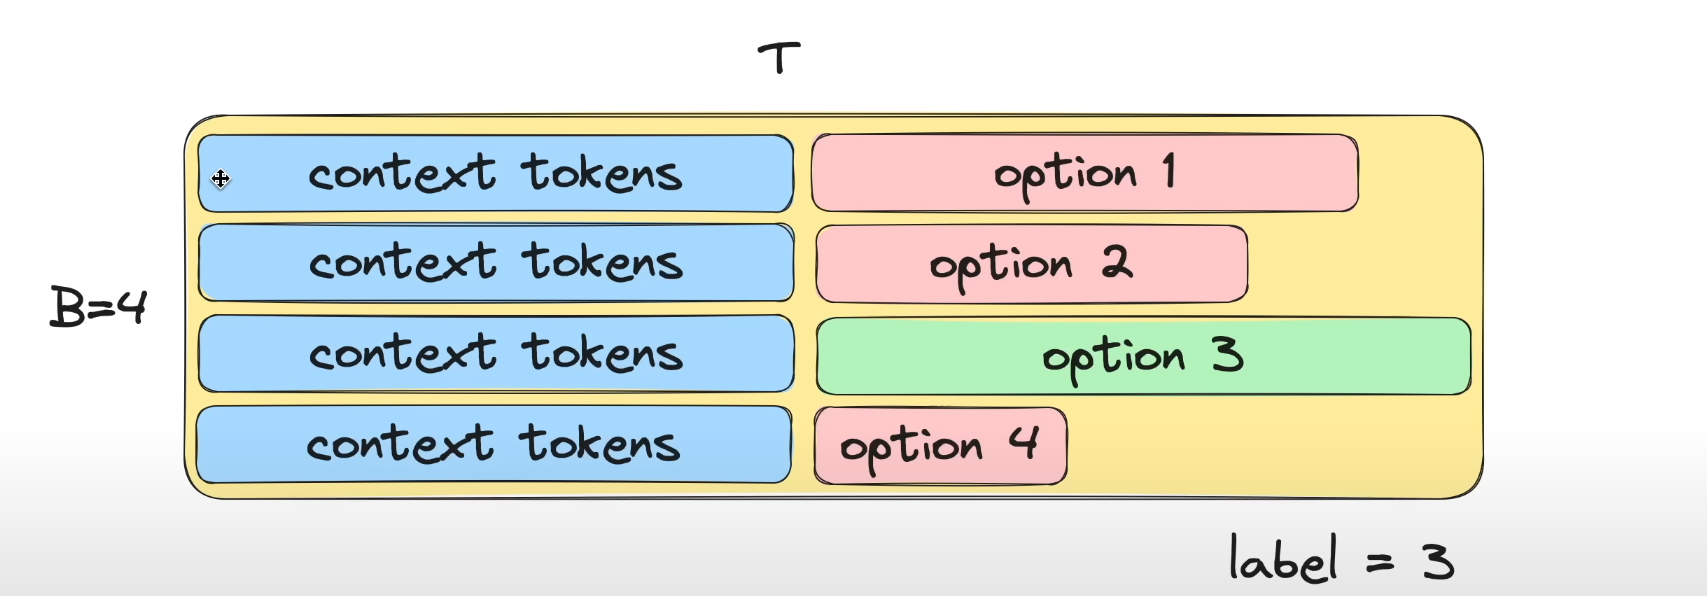
+ 为了时模型能够预测出option3的内容，需要将每行的预测概率取平均，不断反向传播直到模型预测出option3的概率最大